In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor  # Correct import for XGBRegressor
from statsmodels.tsa.arima.model import ARIMA  # Updated import for ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset from a CSV file
# Assuming the CSV file is named 'sales_data.csv'
training_data = pd.read_csv('C:/Users/MSI 11uc/Documents/ML/CW/Q5_datasets/training_data.csv')

In [3]:
# Examine the structure of the dataset
print(training_data.info())
print(training_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614098 entries, 0 to 614097
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   date_id      614098 non-null  object 
 1   item_dept    614098 non-null  object 
 2   item_qty     614098 non-null  float64
 3   net_sales    614098 non-null  float64
 4   store        614098 non-null  object 
 5   item         614098 non-null  int64  
 6   invoice_num  591288 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 32.8+ MB
None
     date_id  item_dept  item_qty  net_sales store    item  invoice_num
0  11/1/2021    Grocery       1.0      160.0   XYZ   16620    1475459.0
1  11/1/2021    Grocery       2.0      480.0   XYZ   32365    1475459.0
2  11/1/2021    Grocery       1.0      127.0   XYZ   31349    1475459.0
3  11/1/2021  Household       2.0      110.0   XYZ    1266    1475475.0
4  11/1/2021  Household       1.0      150.0   XYZ  114920    1475475.0


In [4]:
# Summary statistics for the entire dataset
print(training_data.describe())

            item_qty      net_sales          item   invoice_num
count  614098.000000  614098.000000  614098.00000  5.912880e+05
mean        1.533792     335.067969   67622.41479  4.231954e+06
std         3.058092     824.733169   48909.65677  1.704178e+06
min       -59.000000  -15250.000000     906.00000  1.475419e+06
25%         1.000000     124.000000   14340.00000  2.581947e+06
50%         1.000000     215.000000   89725.00000  4.597865e+06
75%         1.668000     371.000000  117021.00000  5.598286e+06
max       880.000000  316880.280000  124146.00000  9.354809e+06


In [5]:
# Grouping by store and department to get mean, median, and standard deviation of sales
summary_stats = training_data.groupby(['store', 'item_dept'])['net_sales'].agg(['mean', 'median', 'std']).reset_index()
print(summary_stats)

  store  item_dept        mean  median          std
0   ABC  Beverages  441.975939  290.00   719.469928
1   ABC    Grocery  347.082976  203.99  1439.693282
2   ABC  Household  355.436507  230.00   520.681300
3   XYZ  Beverages  382.585788  280.00   454.331200
4   XYZ    Grocery  286.437907  195.52   481.431256
5   XYZ  Household  298.729242  204.00   390.895026


In [6]:
# Sales statistics by date
date_stats = training_data.groupby('date_id')['net_sales'].agg(['mean', 'median', 'std']).reset_index()
print(date_stats)

      date_id        mean  median         std
0    1/1/2022  315.964525  215.00  397.381885
1   1/10/2022  339.473565  220.00  535.510083
2   1/11/2022  376.790450  230.00  710.686714
3   1/12/2022  318.288749  220.00  357.604731
4   1/13/2022  335.934474  215.45  470.089396
..        ...         ...     ...         ...
87  12/5/2021  329.566704  221.00  364.061167
88  12/6/2021  313.799122  207.90  368.463812
89  12/7/2021  295.281183  200.00  333.654962
90  12/8/2021  339.352103  220.00  406.464879
91  12/9/2021  324.655081  220.00  432.573577

[92 rows x 4 columns]


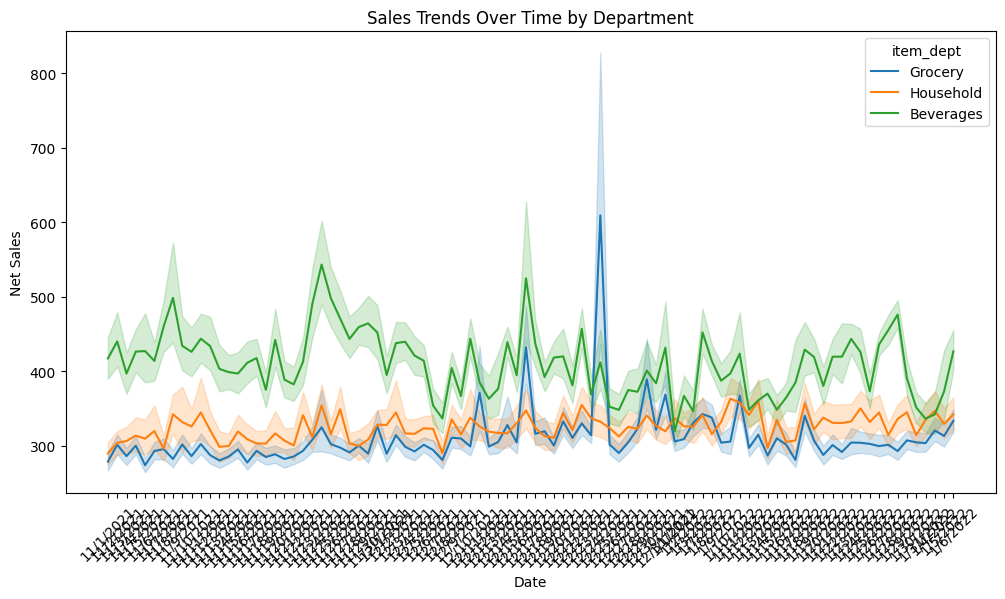

In [7]:
# Time series plot for sales over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=training_data, x='date_id', y='net_sales', hue='item_dept')
plt.title('Sales Trends Over Time by Department')
plt.xlabel('Date')
plt.ylabel('Net Sales')
plt.xticks(rotation=45)
plt.show() 

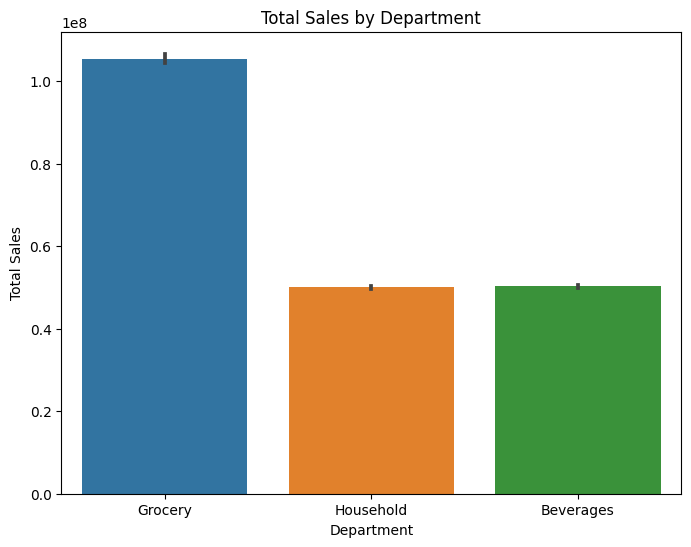

In [8]:
# Bar plot for total sales by department
plt.figure(figsize=(8, 6))
sns.barplot(data=training_data, x='item_dept', y='net_sales', estimator=sum)
plt.title('Total Sales by Department')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.show()

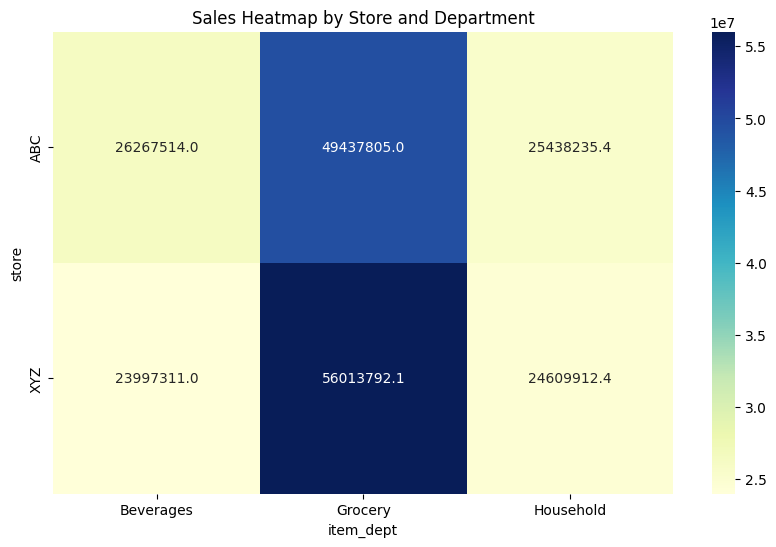

In [9]:
# Heatmap for sales across stores and departments
pivot_table = training_data.pivot_table(values='net_sales', index='store', columns='item_dept', aggfunc='sum')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Sales Heatmap by Store and Department')
plt.show()

day_of_week
Monday       2.740170e+07
Tuesday      2.748833e+07
Wednesday    2.746814e+07
Thursday     3.014797e+07
Friday       3.278485e+07
Saturday     3.006873e+07
Sunday       3.040485e+07
Name: net_sales, dtype: float64


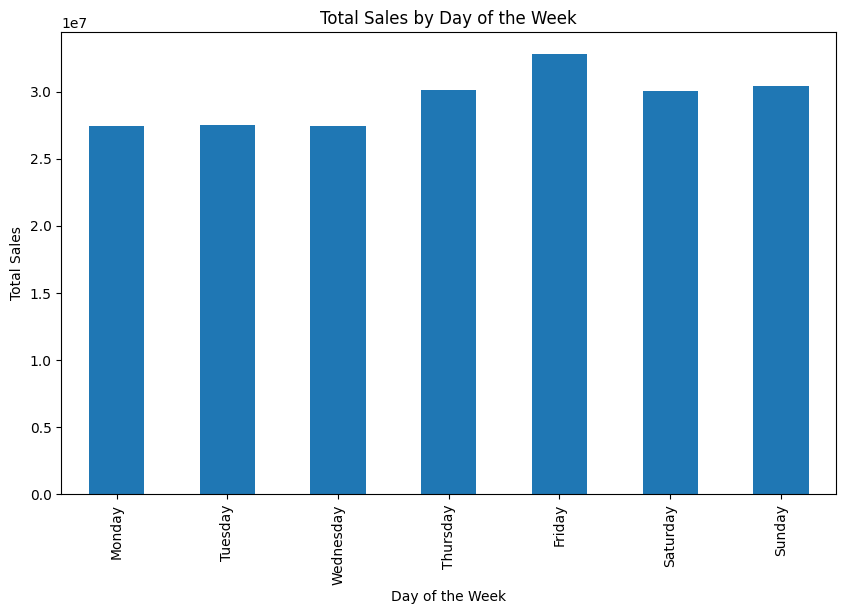

In [10]:
# Convert date_id to datetime format
training_data['date_id'] = pd.to_datetime(training_data['date_id'])

# Add a new column for the day of the week
training_data['day_of_week'] = training_data['date_id'].dt.day_name()

# Group by day of the week to analyze sales patterns
weekday_sales = training_data.groupby('day_of_week')['net_sales'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
print(weekday_sales)

# Plotting the sales pattern over the week
plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

In [11]:
# Check for duplicate rows
duplicate_rows = training_data[training_data.duplicated()]

# Print the duplicate rows, if any
print(f"Number of rows: {training_data.shape[0]}")
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

Number of rows: 614098
Number of duplicate rows: 1766


In [12]:
# Drop duplicate rows
training_data = training_data.drop_duplicates()

In [13]:
# Check for missing values
print(training_data.isnull().sum())

date_id            0
item_dept          0
item_qty           0
net_sales          0
store              0
item               0
invoice_num    21427
day_of_week        0
dtype: int64


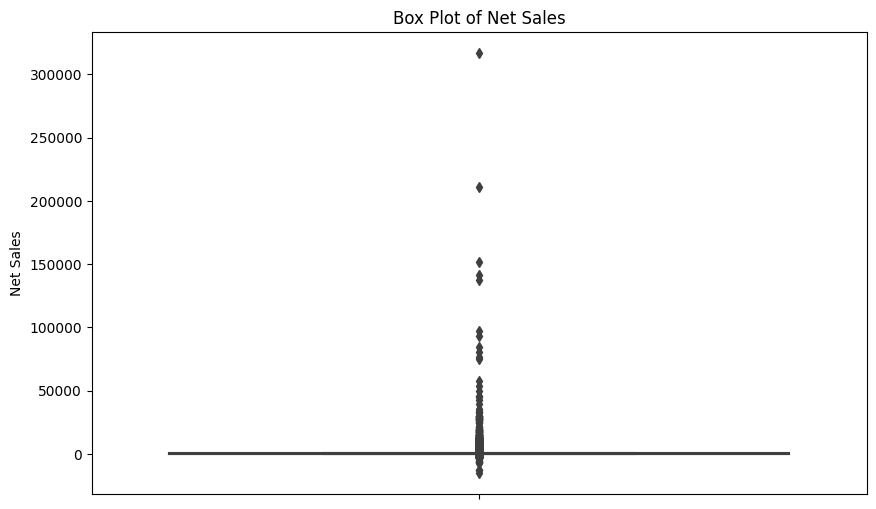

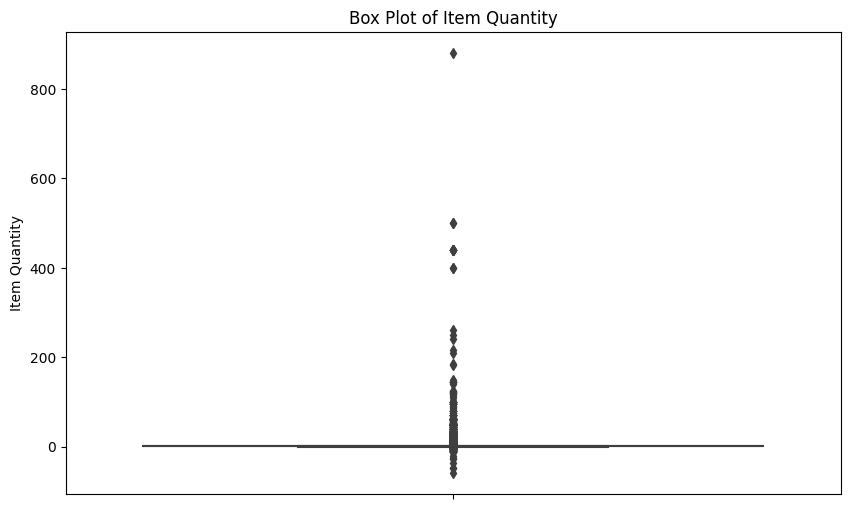

In [14]:
# Box plot for 'net_sales'
plt.figure(figsize=(10, 6))
sns.boxplot(y=training_data['net_sales'])
plt.title('Box Plot of Net Sales')
plt.ylabel('Net Sales')
plt.show()

# Box plot for 'item_qty'
plt.figure(figsize=(10, 6))
sns.boxplot(y=training_data['item_qty'])
plt.title('Box Plot of Item Quantity')
plt.ylabel('Item Quantity')
plt.show()

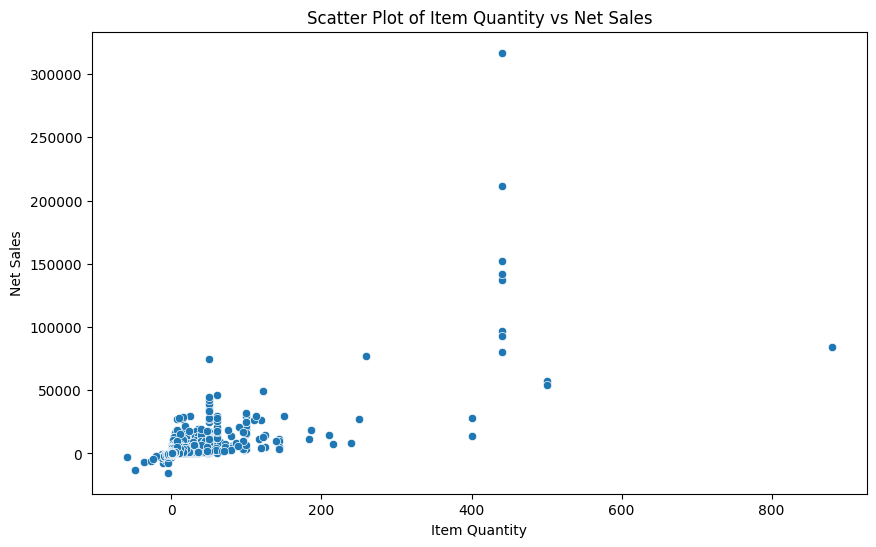

In [15]:
# Scatter plot for 'item_qty' vs 'net_sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=training_data['item_qty'], y=training_data['net_sales'])
plt.title('Scatter Plot of Item Quantity vs Net Sales')
plt.xlabel('Item Quantity')
plt.ylabel('Net Sales')
plt.show()

In [16]:
# Removing the outliers
training_data = training_data[training_data['net_sales'] < 300000]
training_data = training_data[training_data['item_qty'] < 800]

print(f"Number of rows: {training_data.shape[0]}")


Number of rows: 612330


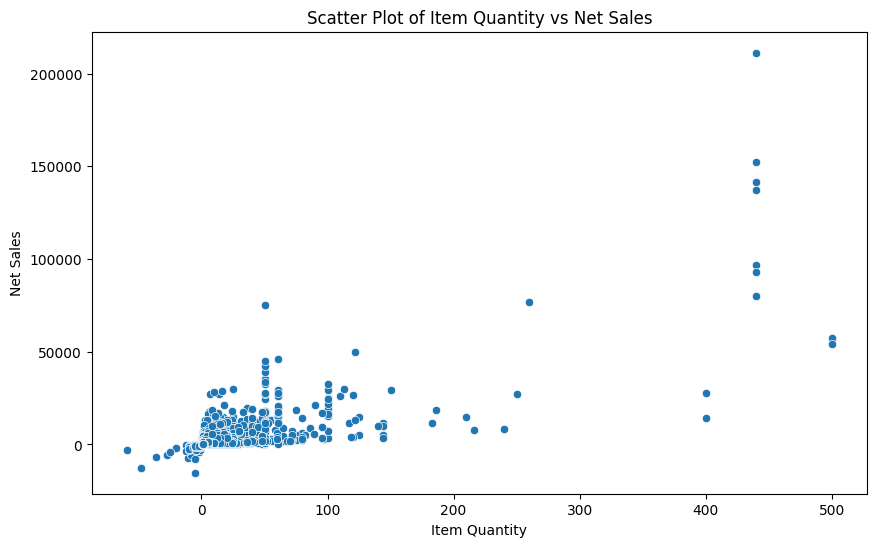

In [17]:
# Scatter plot for 'item_qty' vs 'net_sales'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=training_data['item_qty'], y=training_data['net_sales'])
plt.title('Scatter Plot of Item Quantity vs Net Sales')
plt.xlabel('Item Quantity')
plt.ylabel('Net Sales')
plt.show()

In [18]:
### Groubpy the dataset based on date, net sales, item quantity
grouped_df = training_data.groupby(['date_id', 'store', 'item_dept']).agg({
    'item_qty': 'sum',
    'net_sales': 'sum'
}).reset_index()

# Display the first few rows of the grouped dataframe
print(grouped_df.head())

     date_id store  item_dept  item_qty     net_sales
0 2021-11-01   ABC  Beverages   908.000  254007.79901
1 2021-11-01   ABC    Grocery  2360.399  437286.62402
2 2021-11-01   ABC  Household  1043.000  247336.26601
3 2021-11-01   XYZ  Beverages   779.000  187931.76902
4 2021-11-01   XYZ    Grocery  2974.060  489967.72300


In [19]:
# Ensure that each row is uniquely identified by 'store', 'item_dept', and 'date_id'
grouped_df['primary_key'] = grouped_df['store'] + '|' + grouped_df['item_dept'] + '|' + grouped_df['date_id'].astype(str)

# Check for duplicates based on primary keys
if grouped_df.duplicated(subset=['primary_key']).any():
    print("Warning: There are duplicate rows based on the primary keys.")
else:
    print("All rows are uniquely identified by the primary keys.")

All rows are uniquely identified by the primary keys.


In [20]:
# The target variable is the daily sales quantity for each store and department
target_variable = grouped_df[['store', 'item_dept', 'date_id', 'item_qty']]

# Rename the target variable column for clarity
target_variable.rename(columns={'item_qty': 'daily_sales_qty'}, inplace=True)

# Display the target variable
print(target_variable.head())

  store  item_dept    date_id  daily_sales_qty
0   ABC  Beverages 2021-11-01          908.000
1   ABC    Grocery 2021-11-01         2360.399
2   ABC  Household 2021-11-01         1043.000
3   XYZ  Beverages 2021-11-01          779.000
4   XYZ    Grocery 2021-11-01         2974.060


C:\Users\MSI 11uc\AppData\Local\Temp\ipykernel_26184\297320409.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_variable.rename(columns={'item_qty': 'daily_sales_qty'}, inplace=True)


In [21]:
#### Sales Related Features

In [22]:
# Rolling averages (e.g., 7-day rolling average)
grouped_df['rolling_avg_7d'] = grouped_df.groupby(['store', 'item_dept'])['item_qty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

# Cumulative sales
grouped_df['cumulative_sales'] = grouped_df.groupby(['store', 'item_dept'])['item_qty'].cumsum()

# Lag features (e.g., sales of the previous day)
grouped_df['lag_1d'] = grouped_df.groupby(['store', 'item_dept'])['item_qty'].shift(1)

# Fill NaN values resulting from the shift with 0
grouped_df['lag_1d'].fillna(0, inplace=True)

print(grouped_df.head())

     date_id store  item_dept  item_qty     net_sales  \
0 2021-11-01   ABC  Beverages   908.000  254007.79901   
1 2021-11-01   ABC    Grocery  2360.399  437286.62402   
2 2021-11-01   ABC  Household  1043.000  247336.26601   
3 2021-11-01   XYZ  Beverages   779.000  187931.76902   
4 2021-11-01   XYZ    Grocery  2974.060  489967.72300   

                primary_key  rolling_avg_7d  cumulative_sales  lag_1d  
0  ABC|Beverages|2021-11-01         908.000           908.000     0.0  
1    ABC|Grocery|2021-11-01        2360.399          2360.399     0.0  
2  ABC|Household|2021-11-01        1043.000          1043.000     0.0  
3  XYZ|Beverages|2021-11-01         779.000           779.000     0.0  
4    XYZ|Grocery|2021-11-01        2974.060          2974.060     0.0  


In [23]:
#### Item-Related Features

In [24]:
### Time-Related Features

In [25]:
### # Day of the week
grouped_df['day_of_week'] = grouped_df['date_id'].dt.dayofweek

# Month
grouped_df['month'] = grouped_df['date_id'].dt.month

# Check if the date is a holiday (example using a predefined list of holidays)
holidays = ['2021-11-01']  # Add more holidays as needed
grouped_df['is_holiday'] = grouped_df['date_id'].isin(pd.to_datetime(holidays)).astype(int)

print(grouped_df.head())

     date_id store  item_dept  item_qty     net_sales  \
0 2021-11-01   ABC  Beverages   908.000  254007.79901   
1 2021-11-01   ABC    Grocery  2360.399  437286.62402   
2 2021-11-01   ABC  Household  1043.000  247336.26601   
3 2021-11-01   XYZ  Beverages   779.000  187931.76902   
4 2021-11-01   XYZ    Grocery  2974.060  489967.72300   

                primary_key  rolling_avg_7d  cumulative_sales  lag_1d  \
0  ABC|Beverages|2021-11-01         908.000           908.000     0.0   
1    ABC|Grocery|2021-11-01        2360.399          2360.399     0.0   
2  ABC|Household|2021-11-01        1043.000          1043.000     0.0   
3  XYZ|Beverages|2021-11-01         779.000           779.000     0.0   
4    XYZ|Grocery|2021-11-01        2974.060          2974.060     0.0   

   day_of_week  month  is_holiday  
0            0     11           1  
1            0     11           1  
2            0     11           1  
3            0     11           1  
4            0     11           1  


In [26]:
### Outlet-Related Features

In [27]:
outlet_features = pd.read_csv('C:/Users/MSI 11uc/Documents/ML/CW/Q5_datasets/outlet_info.csv')

# Merge the outlet-related features with the sales data
grouped_df = pd.merge(grouped_df, outlet_features, on='store', how='left')

# Display the merged DataFrame
print(grouped_df.head())

     date_id store  item_dept  item_qty     net_sales  \
0 2021-11-01   ABC  Beverages   908.000  254007.79901   
1 2021-11-01   ABC    Grocery  2360.399  437286.62402   
2 2021-11-01   ABC  Household  1043.000  247336.26601   
3 2021-11-01   XYZ  Beverages   779.000  187931.76902   
4 2021-11-01   XYZ    Grocery  2974.060  489967.72300   

                primary_key  rolling_avg_7d  cumulative_sales  lag_1d  \
0  ABC|Beverages|2021-11-01         908.000           908.000     0.0   
1    ABC|Grocery|2021-11-01        2360.399          2360.399     0.0   
2  ABC|Household|2021-11-01        1043.000          1043.000     0.0   
3  XYZ|Beverages|2021-11-01         779.000           779.000     0.0   
4    XYZ|Grocery|2021-11-01        2974.060          2974.060     0.0   

   day_of_week  month  is_holiday   profile    size  
0            0     11           1  Moderate  Medium  
1            0     11           1  Moderate  Medium  
2            0     11           1  Moderate  Medium  
3 

In [28]:
# Define the path to save the processed data
processed_data_path = 'C:/Users/MSI 11uc/Documents/ML/CW/Q5_datasets/processed_training_data.csv'

# Save the processed data to the specified path
grouped_df.to_csv(processed_data_path, index=False)

print(f"Processed data saved to {processed_data_path}")

Processed data saved to C:/Users/MSI 11uc/Documents/ML/CW/Q5_datasets/processed_training_data.csv


In [38]:
def preprocess_for_xgb(df):
    df_encoded = df.copy()
    
    # Label encoding for categorical features
    label_encoders = {}
    for column in ['store', 'item_dept', 'profile', 'size']:
        le = LabelEncoder()
        df_encoded[column] = le.fit_transform(df_encoded[column])
        label_encoders[column] = le
    
    # Drop unnecessary columns
    df_encoded = df_encoded.drop(columns=['primary_key', 'date_id'])
    
    return df_encoded, label_encoders

def preprocess_for_lstm(df):
    # Ensure all columns are numeric
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Handle any missing values (optional: you could also drop or fill missing values)
    numeric_df = numeric_df.fillna(0)
    
    # Normalize the features (optional, but recommended for neural networks)
    X = numeric_df.drop(columns=['net_sales']).values.astype('float32')
    y = numeric_df['net_sales'].values.astype('float32')
    
    # Reshape input for LSTM [samples, timesteps, features]
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    
    return X_reshaped, y

def train_arima(df, store, item_dept):
    # Filter the data for the specific store and item_dept
    series = df[(df['store'] == store) & (df['item_dept'] == item_dept)]['net_sales']
    
    # Train ARIMA model
    arima_model = ARIMA(series, order=(5, 1, 0))
    arima_fit = arima_model.fit()
    
    return arima_fit

def train_models(df):
    # Preprocess data for XGBoost
    df_xgb, label_encoders = preprocess_for_xgb(df)
    
    # Split data into training and validation sets for XGBoost
    X = df_xgb.drop(columns=['net_sales'])
    y = df_xgb['net_sales']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train XGBoost model
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)
    
    # Evaluate XGBoost
    xgb_predictions = xgb_model.predict(X_val)
    xgb_rmse = mean_squared_error(y_val, xgb_predictions, squared=False)
    print(f"XGBoost RMSE: {xgb_rmse}")
    
    # Train ARIMA models for each store and item_dept
    arima_models = {}
    for store in df['store'].unique():
        for item_dept in df['item_dept'].unique():
            arima_fit = train_arima(df, store, item_dept)
            arima_models[(store, item_dept)] = arima_fit
    
    # Preprocess data for LSTM
    X_lstm, y_lstm = preprocess_for_lstm(df)
    
    # Split data into training and validation sets for LSTM
    X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)
    
    # Train LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, verbose=1)
    
    # Evaluate LSTM
    lstm_predictions = lstm_model.predict(X_val_lstm)
    lstm_rmse = mean_squared_error(y_val_lstm, lstm_predictions, squared=False)
    print(f"LSTM RMSE: {lstm_rmse}")
    
    return xgb_model, arima_models, lstm_model, label_encoders

In [30]:
'''
def main():
    file_path = 'path_to_your_dataset.csv'
    
    # Feature engineering pipeline
    df = load_and_preprocess_data(file_path)
    master_table = combine_features(df)
    
    # Model training pipeline
    arima_model, xgb_model, lstm_model = train_models(master_table)
    
if __name__ == "__main__":
    main()

'''

'\ndef main():\n    file_path = \'path_to_your_dataset.csv\'\n    \n    # Feature engineering pipeline\n    df = load_and_preprocess_data(file_path)\n    master_table = combine_features(df)\n    \n    # Model training pipeline\n    arima_model, xgb_model, lstm_model = train_models(master_table)\n    \nif __name__ == "__main__":\n    main()\n\n'

In [45]:
def evaluate_models_with_mape(df, xgb_model, arima_models, lstm_model, label_encoders):
    def calculate_mape(y_true, y_pred):
        """Calculate Mean Absolute Percentage Error (MAPE)."""
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def evaluate_model(df, model, model_name, granularity):
        mape_values = []
        
        if granularity == 'date_id | store | item_dept':
            grouped = df.groupby(['store', 'item_dept', 'date_id'])
        elif granularity == 'date_id | store':
            grouped = df.groupby(['store', 'date_id'])
        else:
            raise ValueError("Unsupported granularity")
        
        for name, group in grouped:
            actual = group['net_sales']
            
            if model_name == 'XGBoost':
                # Ensure all features used in training are included
                group_encoded = group.copy()
                
                # Encode categorical features using the label encoders
                group_encoded['store'] = label_encoders['store'].transform(group_encoded['store'])
                group_encoded['item_dept'] = label_encoders['item_dept'].transform(group_encoded['item_dept'])
                group_encoded['profile'] = label_encoders['profile'].transform(group_encoded['profile'])
                group_encoded['size'] = label_encoders['size'].transform(group_encoded['size'])

                # Drop target and unnecessary columns
                group_encoded = group_encoded.drop(columns=['net_sales', 'primary_key', 'date_id'])
                pred = model.predict(group_encoded)
                
            elif model_name == 'LSTM':
                X_lstm, _ = preprocess_for_lstm(group)
                pred = model.predict(X_lstm).flatten()
                
            elif model_name == 'ARIMA':
                pred = model[(group['store'].iloc[0], group['item_dept'].iloc[0])].forecast(steps=len(group))
            
            mape = calculate_mape(actual, pred)
            mape_values.append(mape)
        
        avg_mape = np.mean(mape_values)
        print(f"{model_name} MAPE ({granularity}): {avg_mape}%")
    
    # Evaluate XGBoost
    evaluate_model(df, xgb_model, 'XGBoost', 'date_id | store | item_dept')
    evaluate_model(df, xgb_model, 'XGBoost', 'date_id | store')
    
    # Evaluate ARIMA
    evaluate_model(df, arima_models, 'ARIMA', 'date_id | store | item_dept')
    evaluate_model(df, arima_models, 'ARIMA', 'date_id | store')
    
    # Evaluate LSTM
    evaluate_model(df, lstm_model, 'LSTM', 'date_id | store | item_dept')
    evaluate_model(df, lstm_model, 'LSTM', 'date_id | store')


In [46]:
def main():
    
    # Model training pipeline
    xgb_model, arima_models, lstm_model, label_encoders = train_models(grouped_df)
    
    # Evaluation pipeline
    evaluate_models_with_mape(grouped_df, xgb_model, arima_models, lstm_model, label_encoders)
    
if __name__ == "__main__":
    main()

XGBoost RMSE: 36666.68471939203


c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

Epoch 1/10


c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\MSI 11uc\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 152220532736.0000
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 144330850304.0000
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132275609600.0000 
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127699312640.0000 
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117685379072.0000 
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117762220032.0000
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111900721152.0000 
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104376442880.0000 
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107281793024.0000
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94421303296.0000 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
LSTM RMSE: 290587.90625
XGBoost MAPE (date_id | store | item_dept): 1.8451626821163116%
XGBoost MAPE (date_id | store): 1.8451626821163116%


c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-pac

ARIMA MAPE (date_id | store | item_dept): nan%


c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\MSI 11uc\anaconda3\lib\site-pac

ARIMA MAPE (date_id | store): nan%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━